(GP-Heteroskedastic)=
# Heteroskedastic Gaussian Processes

:::{post} May 5, 2021
:tags: gaussian process, heteroskedastic, coregionalization
:category: intermediate
:author: John Goertz
:::


We can typically divide the sources of uncertainty in our models into two categories. "Aleatoric" uncertainty (from the Latin word for dice or randomness) arises from the intrinsic variability of our system. "Epistemic" uncertainty (from the Greek word for knowledge) arises from how our observations are placed throughout the domain of interest.

Gaussian Process (GP) models are powerful tools for capturing both of these sources of uncertainty. By considering the distribution of all functions that satisfy the conditions specified by the covariance kernel and the data, these models express low epistemic uncertainty near the observations and high epistemic uncertainty farther away. To incorporate aleatoric uncertainty, the standard GP model assumes additive white noise with constant magnitude throughout the domain. However, this "homoskedastic" model can do a poor job of representing your system if some regions have higher variance than others. Among other fields, this is particularly common in the experimental sciences, where varying experimental parameters can affect both the magnitude and the variability of the response. Explicitly incorporating the dependence (and interdependence) of noise on the inputs and outputs can lead to a better understanding of the mean behavior as well as a more informative landscape for optimization, for example.

This notebook will work through several approaches to heteroskedastic modeling with GPs. We'll use toy data that represents (independent) repeated measurements at a range of input values on a system where the magnitude of the noise increases with the response variable. We'll start with simplistic modeling approaches such as fitting a GP to the mean at each point weighted by the variance at each point (which may be useful if individual measurements are taken via a method with known uncertainty), contrasting this with a typical homoskedastic GP. We'll then construct a model that uses one latent GP to model the response mean and a second (independent) latent GP to model the response variance. To improve the efficiency and scalability of this model, we'll reformulate it in a sparse framework. Finally, we'll use a coregionalization kernel to allow correlation between the noise and the mean response.

## Data

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

from scipy.spatial.distance import pdist

%config InlineBackend.figure_format ='retina'

In [2]:
SEED = 2020
rng = np.random.default_rng(SEED)
az.style.use("arviz-darkgrid")

<ErrorbarContainer object of 3 artists>

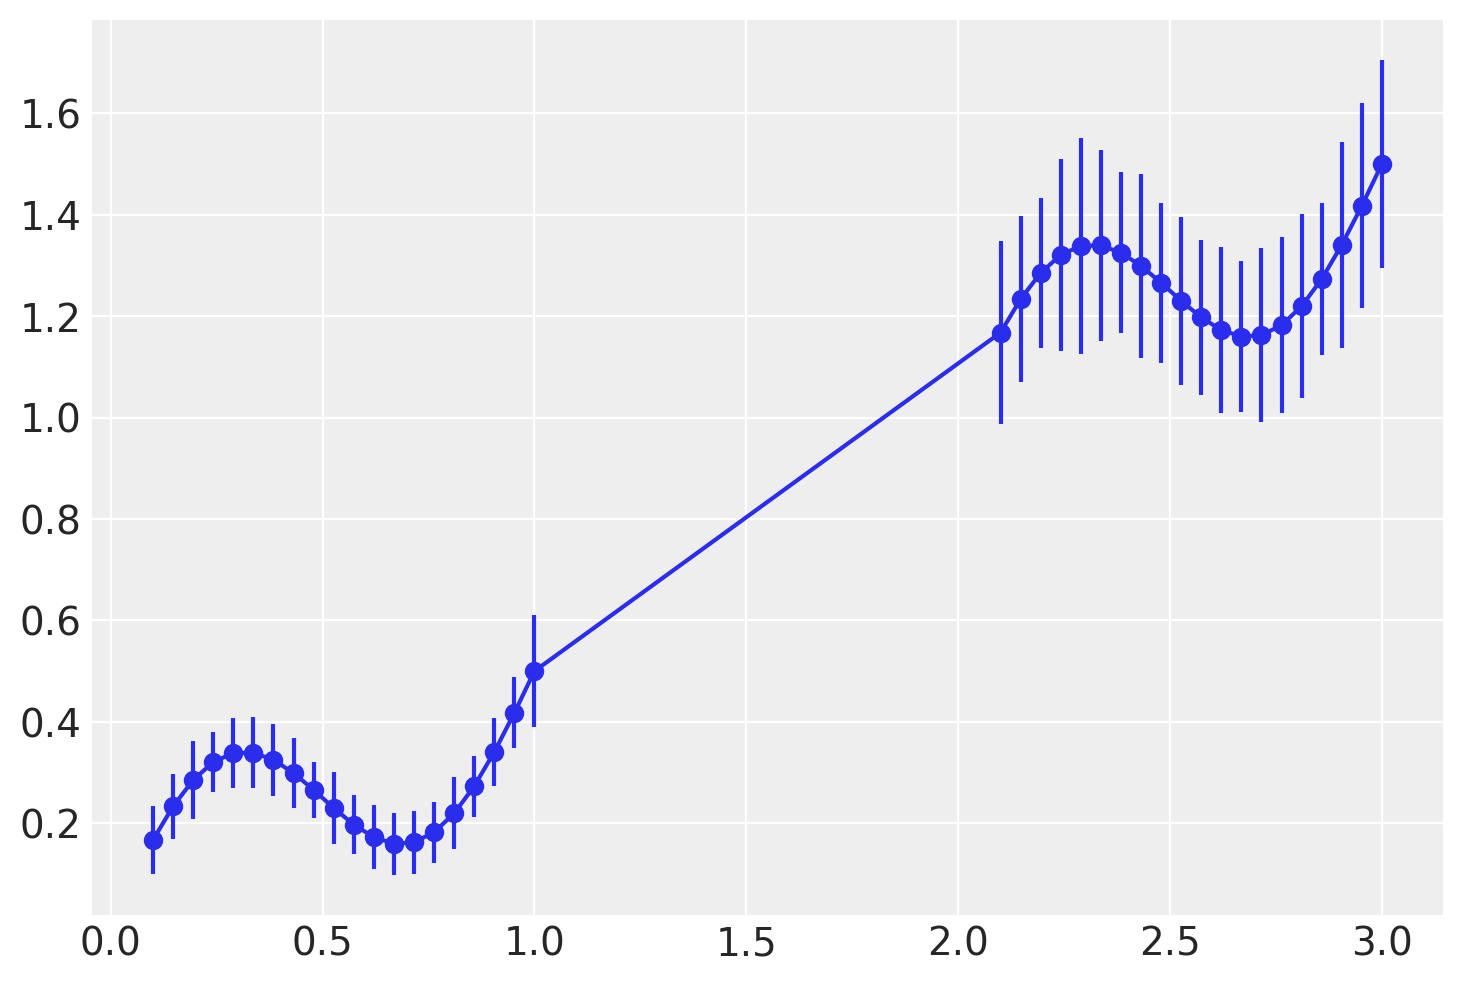

In [3]:
def signal(x):
    return x / 2 + np.sin(2 * np.pi * x) / 5


def noise(y):
    return np.exp(y) / 20


X = np.linspace(0.1, 1, 20)[:, None]
X = np.vstack([X, X + 2])
X_ = X.flatten()
y = signal(X_)
σ_fun = noise(y)

y_err = rng.lognormal(np.log(σ_fun), 0.1)
y_obs = rng.normal(y, y_err, size=(5, len(y)))
y_obs_ = y_obs.T.flatten()
X_obs = np.tile(X.T, (5, 1)).T.reshape(-1, 1)
X_obs_ = X_obs.flatten()
idx = np.tile(np.array([i for i, _ in enumerate(X_)]), (5, 1)).T.flatten()

Xnew = np.linspace(-0.15, 3.25, 100)[:, None]
Xnew_ = Xnew.flatten()
ynew = signal(Xnew)

plt.plot(X, y, "C0o")
plt.errorbar(X_, y, y_err, color="C0")

## Helper and plotting functions

In [4]:
def get_ℓ_prior(points):
    """Calculates mean and sd for InverseGamma prior on lengthscale"""
    distances = pdist(points[:, None])
    distinct = distances != 0
    ℓ_l = distances[distinct].min() if sum(distinct) > 0 else 0.1
    ℓ_u = distances[distinct].max() if sum(distinct) > 0 else 1
    ℓ_σ = max(0.1, (ℓ_u - ℓ_l) / 6)
    ℓ_μ = ℓ_l + 3 * ℓ_σ
    return ℓ_μ, ℓ_σ


ℓ_μ, ℓ_σ = (stat for stat in get_ℓ_prior(X_))

In [5]:
def plot_inducing_points(ax):
    yl = ax.get_ylim()
    yu = -np.subtract(*yl) * 0.025 + yl[0]
    ax.plot(Xu, np.full(Xu.shape, yu), "xk", label="Inducing Points")
    ax.legend(loc="upper left")


def get_quantiles(samples, quantiles=[2.5, 50, 97.5], sample_axis=0):
    return [np.percentile(samples, p, axis=sample_axis) for p in quantiles]


def plot_mean(ax, mean_samples, sample_axis=0):
    """Plots the median and 95% CI from samples of the mean

    Note that, although each individual GP exhibits a normal distribution at each point
    (by definition), we are sampling from a mixture of GPs defined by the posteriors of
    our hyperparameters. As such, we use percentiles rather than mean +/- stdev to
    represent the spread of predictions from our models.
    """
    l, m, u = get_quantiles(mean_samples, sample_axis=sample_axis)
    ax.plot(Xnew, m, "C0", label="Median")
    ax.fill_between(Xnew_, l, u, facecolor="C0", alpha=0.5, label="95% CI")

    ax.plot(Xnew, ynew, "--k", label="Mean Function")
    ax.plot(X, y, "C1.", label="Observed Means")
    ax.set_title("Mean Behavior")
    ax.legend(loc="upper left")


def plot_var(ax, var_samples, sample_axis=0):
    """Plots the median and 95% CI from samples of the variance"""
    if var_samples.squeeze().ndim == 1:
        ax.plot(Xnew, var_samples, "C0", label="Median")
    else:
        l, m, u = get_quantiles(var_samples, sample_axis=sample_axis)
        ax.plot(Xnew, m, "C0", label="Median")
        ax.fill_between(Xnew.flatten(), l, u, facecolor="C0", alpha=0.5, label="95% CI")
    ax.plot(Xnew, noise(signal(Xnew_)) ** 2, "--k", label="Noise Function")
    ax.plot(X, y_err**2, "C1.", label="Observed Variance")
    ax.set_title("Variance Behavior")
    ax.legend(loc="upper left")


def plot_total(ax, mean_samples, var_samples=None, sample_axis=0, bootstrap=True, n_boots=100):
    """Plots the overall mean and variance of the aggregate system

    We can represent the overall uncertainty via explicitly sampling the underlying normal
    distributrions (with `bootstrap=True`) or as the mean +/- the standard deviation from
    the Law of Total Variance. For systems with many observations, there will likely be
    little difference, but in cases with few observations and informative priors, plotting
    the percentiles will likely give a more accurate representation.
    """

    if (var_samples is None) or (var_samples.squeeze().ndim == 1):
        samples = mean_samples
        l, m, u = get_quantiles(samples, sample_axis=sample_axis)
        ax.plot(Xnew, m, "C0", label="Median")
    elif bootstrap:
        # Estimate the aggregate behavior using samples from each normal distribution in the posterior
        samples = rng.normal(
            mean_samples[:, :, None],
            np.sqrt(var_samples)[:, :, None],
            (*mean_samples.shape, n_boots),
        )
        quantile_axis = (0, 2) if sample_axis == 0 else (1, 2)
        l, m, u = get_quantiles(samples, sample_axis=quantile_axis)
        ax.plot(Xnew, m, "C0", label="Median")
    else:
        m = mean_samples.mean(axis=sample_axis)
        ax.plot(Xnew, m, "C0", label="Mean")
        sd = np.sqrt(mean_samples.var(axis=sample_axis) + var_samples.mean(axis=sample_axis))
        l, u = m - 2 * sd, m + 2 * sd

    ax.fill_between(Xnew.flatten(), l, u, facecolor="C0", alpha=0.5, label="Total 95% CI")

    ax.plot(Xnew, ynew, "--k", label="Mean Function")
    ax.plot(X_obs, y_obs_, "C1.", label="Observations")
    ax.set_title("Aggregate Behavior")
    ax.legend(loc="upper left")


## Homoskedastic GP

First, let's fit a standard homoskedastic GP using PyMC's `Marginal Likelihood` implementation. Here and throughout this notebook we'll use an informative prior for length scale as suggested by [Michael Betancourt](https://betanalpha.github.io/assets/case_studies/gp_part3/part3.html#4_adding_an_informative_prior_for_the_length_scale). We could use `pm.find_MAP()` and `.predict` for even faster inference and prediction, with similar results, but for direct comparison to the other models we'll use NUTS and `.conditional` instead, which run fast enough.

In [6]:
with pm.Model() as model_hm:
    ℓ = pm.InverseGamma("ℓ", mu=ℓ_μ, sigma=ℓ_σ)
    η = pm.Gamma("η", alpha=2, beta=1)
    cov = η**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ℓ)

    gp_hm = pm.gp.Marginal(cov_func=cov)

    σ = pm.Exponential("σ", lam=1)

    ml_hm = gp_hm.marginal_likelihood("ml_hm", X=X_obs, y=y_obs_, sigma=σ)

    trace_hm = pm.sample(return_inferencedata=True, random_seed=SEED)

with model_hm:
    mu_pred_hm = gp_hm.conditional("mu_pred_hm", Xnew=Xnew)
    noisy_pred_hm = gp_hm.conditional("noisy_pred_hm", Xnew=Xnew, pred_noise=True)
    samples_hm = pm.sample_posterior_predictive(trace_hm, var_names=["mu_pred_hm", "noisy_pred_hm"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, η, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
Sampling: [mu_pred_hm, noisy_pred_hm]


Output()

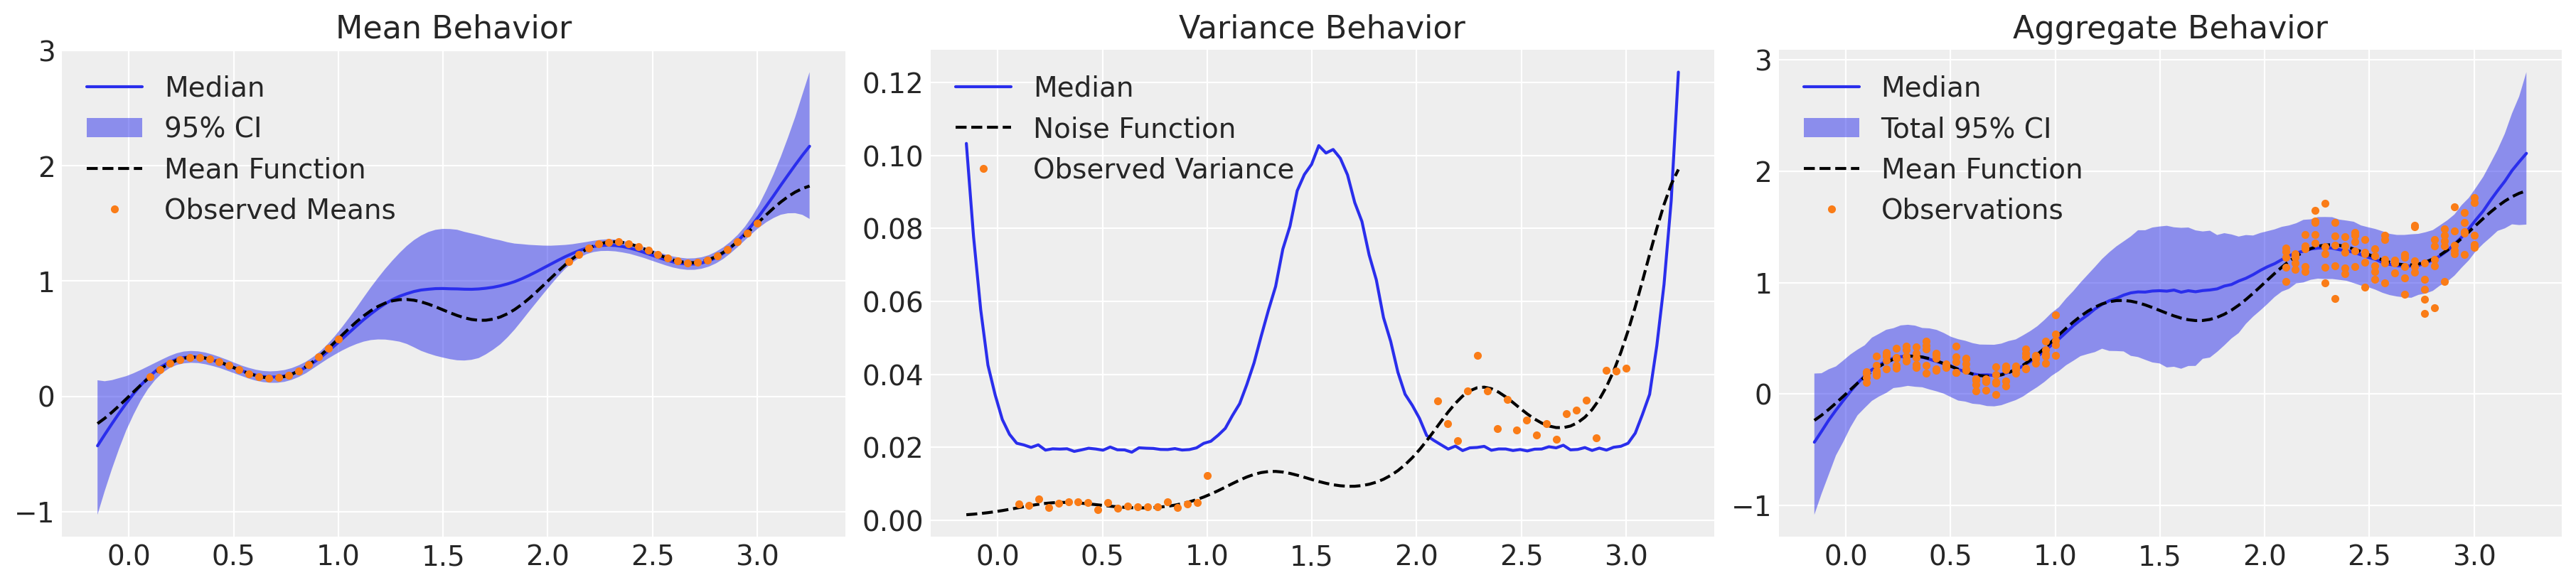

In [7]:
_, axs = plt.subplots(1, 3, figsize=(18, 4))
ppc_hm = samples_hm.posterior_predictive.stack(sample=("chain", "draw"))
mu_samples = ppc_hm["mu_pred_hm"].values
noisy_samples = ppc_hm["noisy_pred_hm"].values
plot_mean(axs[0], mu_samples, sample_axis=1)
plot_var(axs[1], noisy_samples.var(axis=1))
plot_total(axs[2], noisy_samples, sample_axis=1)


Here we've plotted our understanding of the mean behavior with the corresponding epistemic uncertainty on the left, our understanding of the variance or aleatoric uncertainty in the middle, and integrated all sources of uncertainty on the right. This model captures the mean behavior well, but we can see that it overestimates the noise in the lower regime while underestimating the noise in the upper regime, as expected.

## Variance-weighted GP

The simplest approach to modeling a heteroskedastic system is to fit a GP on the mean at each point along the domain and supply the standard deviation as weights.

In [8]:
with pm.Model() as model_wt:
    ℓ = pm.InverseGamma("ℓ", mu=ℓ_μ, sigma=ℓ_σ)
    η = pm.Gamma("η", alpha=2, beta=1)
    cov = η**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ℓ)

    gp_wt = pm.gp.Marginal(cov_func=cov)

    ml_wt = gp_wt.marginal_likelihood("ml_wt", X=X, y=y, sigma=y_err)

    trace_wt = pm.sample(return_inferencedata=True, random_seed=SEED)

with model_wt:
    mu_pred_wt = gp_wt.conditional("mu_pred_wt", Xnew=Xnew)
    samples_wt = pm.sample_posterior_predictive(trace_wt, var_names=["mu_pred_wt"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, η]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [mu_pred_wt]


Output()

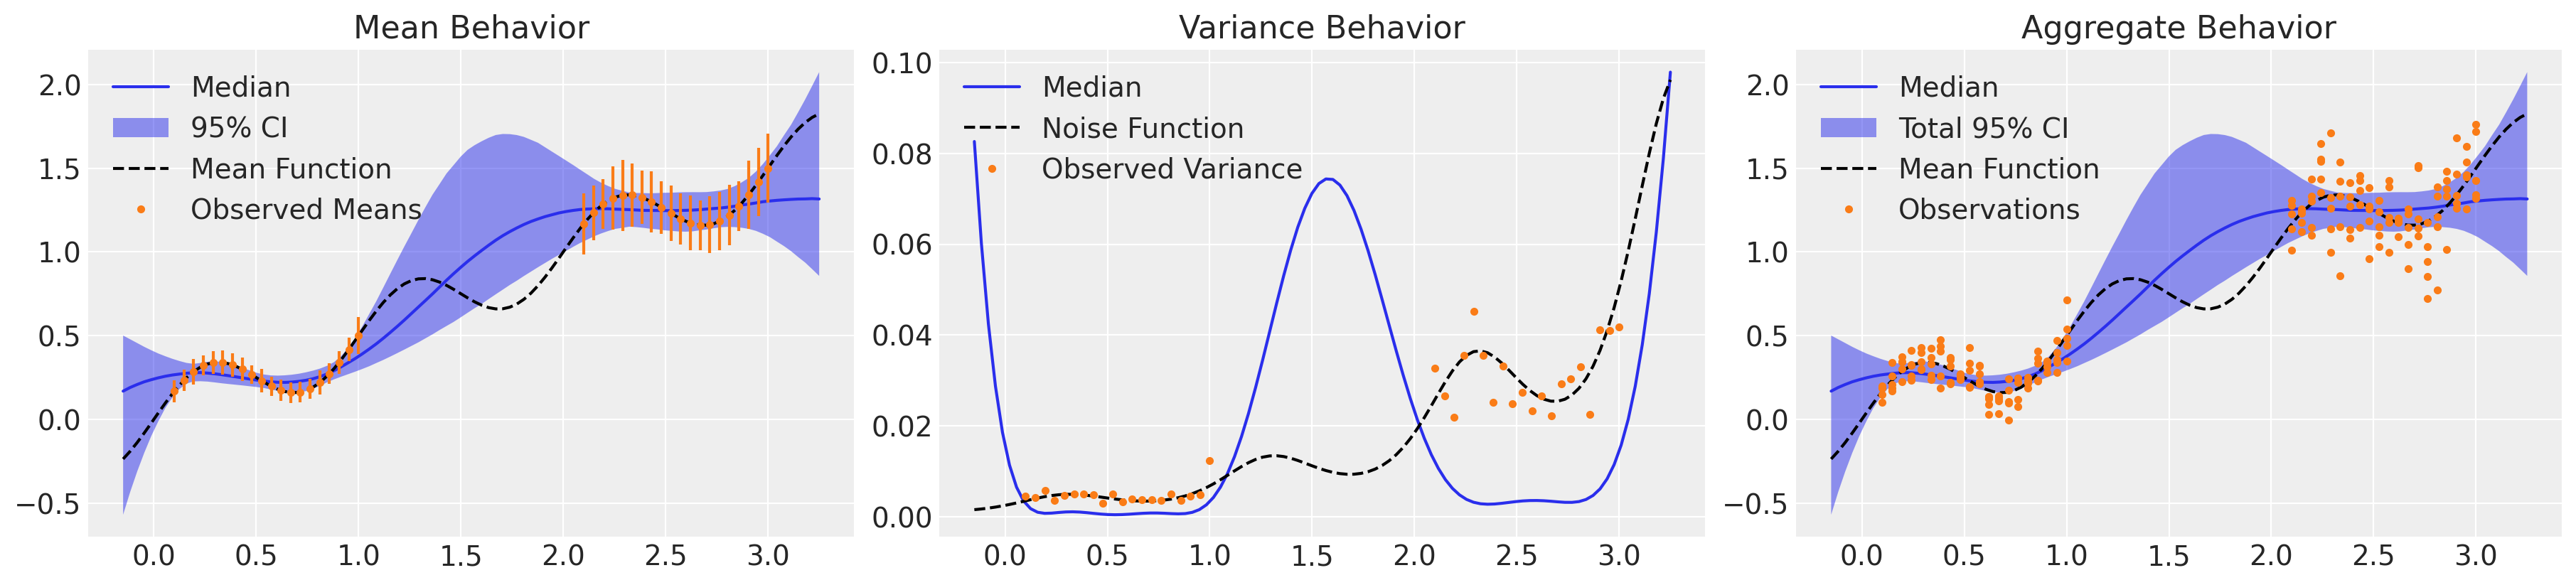

In [9]:
_, axs = plt.subplots(1, 3, figsize=(18, 4))
mu_samples = (
    samples_wt.posterior_predictive.stack(sample=("chain", "draw"))["mu_pred_wt"].values
)
plot_mean(axs[0], mu_samples, sample_axis=1)
axs[0].errorbar(X_, y, y_err, ls="none", color="C1", label="STDEV")
plot_var(axs[1], mu_samples.var(axis=1))
plot_total(axs[2], mu_samples, sample_axis=1)


This approach captured slightly more nuance in the overall uncertainty than the homoskedastic GP, but still underestimated the variance within both the observed regimes. Note that the variance displayed by this model is purely epistemic: our understanding of the mean behavior is weighted by the uncertainty in our observations, but we didn't include a component to account for aleatoric noise.

## Heteroskedastic GP: latent variance model

Now let's model the mean and the log of the variance as separate GPs through PyMC's `Latent` implementation, feeding both into a `Normal` likelihood. Note that we add a small amount of diagonal noise to the individual covariances in order to stabilize them for inversion.

In [ ]:
with pm.Model() as model_ht:
    ℓ = pm.InverseGamma("ℓ", mu=ℓ_μ, sigma=ℓ_σ)
    η = pm.Gamma("η", alpha=2, beta=1)
    cov = η**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ℓ) + pm.gp.cov.WhiteNoise(sigma=1e-6)

    gp_ht = pm.gp.Latent(cov_func=cov)
    μ_f = gp_ht.prior("μ_f", X=X_obs)

    σ_ℓ = pm.InverseGamma("σ_ℓ", mu=ℓ_μ, sigma=ℓ_σ)
    σ_η = pm.Gamma("σ_η", alpha=2, beta=1)
    σ_cov = σ_η**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=σ_ℓ) + pm.gp.cov.WhiteNoise(sigma=1e-6)

    σ_gp = pm.gp.Latent(cov_func=σ_cov)
    lg_σ_f = σ_gp.prior("lg_σ_f", X=X_obs)
    σ_f = pm.Deterministic("σ_f", pm.math.exp(lg_σ_f))

    lik_ht = pm.Normal("lik_ht", mu=μ_f, sigma=σ_f, observed=y_obs_)

    trace_ht = pm.sample(target_accept=0.95, chains=2, return_inferencedata=True, random_seed=SEED)

with model_ht:
    μ_pred_ht = gp_ht.conditional("μ_pred_ht", Xnew=Xnew)
    lg_σ_pred_ht = σ_gp.conditional("lg_σ_pred_ht", Xnew=Xnew)
    samples_ht = pm.sample_posterior_predictive(trace_ht, var_names=["μ_pred_ht", "lg_σ_pred_ht"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ℓ, η, μ_f_rotated_, σ_ℓ, σ_η, lg_σ_f_rotated_]


Output()

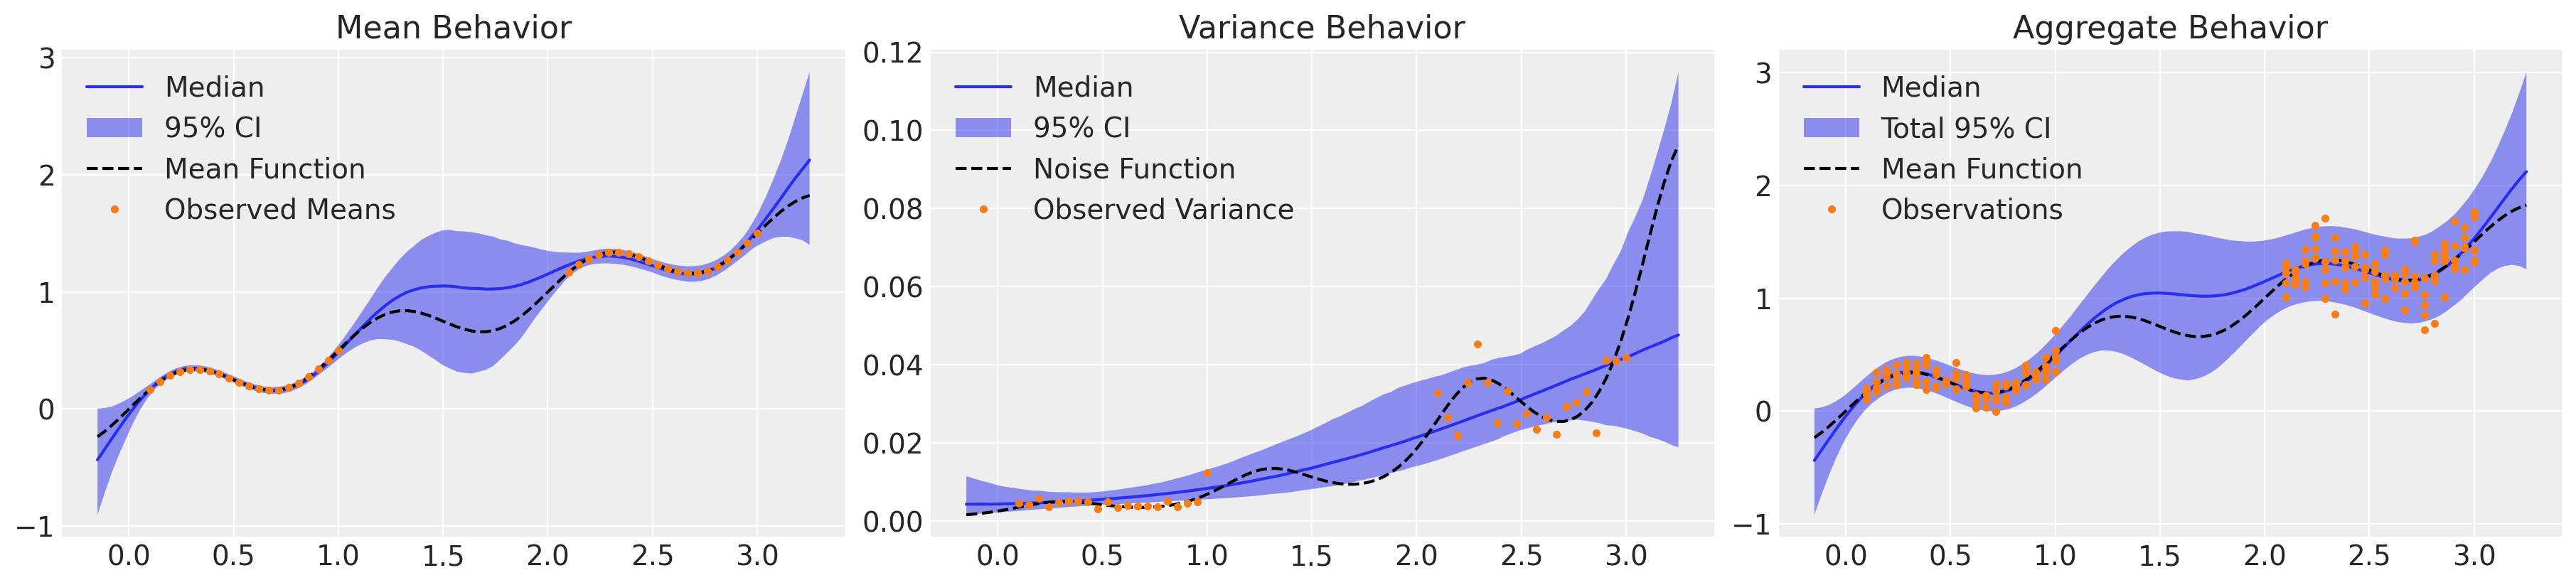

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(18, 4))
ppc_ht = samples_ht.posterior_predictive.stack(sample=("chain", "draw"))
μ_samples = ppc_ht["μ_pred_ht"].values
σ_samples = np.exp(ppc_ht["lg_σ_pred_ht"].values)
plot_mean(axs[0], μ_samples, sample_axis=1)
plot_var(axs[1], σ_samples**2, sample_axis=1)
plot_total(axs[2], μ_samples, σ_samples**2, sample_axis=1)


That looks much better! We've accurately captured the mean behavior of our system along with an understanding of the underlying trend in the variance, with appropriate uncertainty. Crucially, the aggregate behavior of the model integrates both epistemic *and* aleatoric uncertainty, and the ~5% of our observations that fall outside the 2σ band are more or less evenly distributed across the domain. However, that took *over two hours* to sample only 4k NUTS iterations. Due to the expense of the requisite matrix inversions, GPs are notoriously inefficient for large data sets. Let's reformulate this model using a sparse approximation.

### Sparse Heteroskedastic GP

Sparse approximations to GPs use a small set of *inducing points* to condition the model, vastly improve the speed of inference and somewhat improve memory consumption. PyMC doesn't have an implementation for sparse latent GPs ([yet](https://github.com/pymc-devs/pymc/pull/2951)), but we can throw together our own real quick using Bill Engel's [DTC latent GP example](https://gist.github.com/bwengals/a0357d75d2083657a2eac85947381a44). These inducing points can be specified in a variety of ways, such as via the popular k-means initialization or even optimized as part of the model, but since our observations are evenly distributed we can make do with simply a subset of our unique input values.

In [ ]:
class SparseLatent:
    def __init__(self, cov_func):
        self.cov = cov_func

    def prior(self, name, X, Xu):
        Kuu = self.cov(Xu)
        self.L = pt.linalg.cholesky(pm.gp.util.stabilize(Kuu))

        self.v = pm.Normal(f"u_rotated_{name}", mu=0.0, sigma=1.0, shape=len(Xu))
        self.u = pm.Deterministic(f"u_{name}", pt.dot(self.L, self.v))

        Kfu = self.cov(X, Xu)
        self.Kuiu = pt.linalg.solve_triangular(
            self.L.T,
            pt.linalg.solve_triangular(self.L, self.u, lower=True),
            lower=False,
        )
        self.mu = pm.Deterministic(f"mu_{name}", pt.dot(Kfu, self.Kuiu))
        return self.mu

    def conditional(self, name, Xnew, Xu):
        Ksu = self.cov(Xnew, Xu)
        mus = pt.dot(Ksu, self.Kuiu)
        tmp = pt.linalg.solve_triangular(self.L, Ksu.T, lower=True)
        Qss = pt.dot(tmp.T, tmp)  # Qss = pt.dot(pt.dot(Ksu, pt.nlinalg.pinv(Kuu)), Ksu.T)
        Kss = self.cov(Xnew)
        Lss = pt.linalg.cholesky(pm.gp.util.stabilize(Kss - Qss))
        mu_pred = pm.MvNormal(name, mu=mus, chol=Lss, shape=len(Xnew))
        return mu_pred

In [ ]:
# Explicitly specify inducing points by downsampling our input vector
Xu = X[1::2]

with pm.Model() as model_hts:
    ℓ = pm.InverseGamma("ℓ", mu=ℓ_μ, sigma=ℓ_σ)
    η = pm.Gamma("η", alpha=2, beta=1)
    cov = η**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ℓ)

    μ_gp = SparseLatent(cov)
    μ_f = μ_gp.prior("μ", X_obs, Xu)

    σ_ℓ = pm.InverseGamma("σ_ℓ", mu=ℓ_μ, sigma=ℓ_σ)
    σ_η = pm.Gamma("σ_η", alpha=2, beta=1)
    σ_cov = σ_η**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=σ_ℓ)

    lg_σ_gp = SparseLatent(σ_cov)
    lg_σ_f = lg_σ_gp.prior("lg_σ_f", X_obs, Xu)
    σ_f = pm.Deterministic("σ_f", pm.math.exp(lg_σ_f))

    lik_hts = pm.Normal("lik_hts", mu=μ_f, sigma=σ_f, observed=y_obs_)
    trace_hts = pm.sample(target_accept=0.95, return_inferencedata=True, random_seed=SEED)

with model_hts:
    μ_pred = μ_gp.conditional("μ_pred", Xnew, Xu)
    lg_σ_pred = lg_σ_gp.conditional("lg_σ_pred", Xnew, Xu)
    samples_hts = pm.sample_posterior_predictive(trace_hts, var_names=["μ_pred", "lg_σ_pred"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, η, u_rotated_μ, σ_ℓ, σ_η, u_rotated_lg_σ_f]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1332 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling: [lg_σ_pred, μ_pred]


Output()

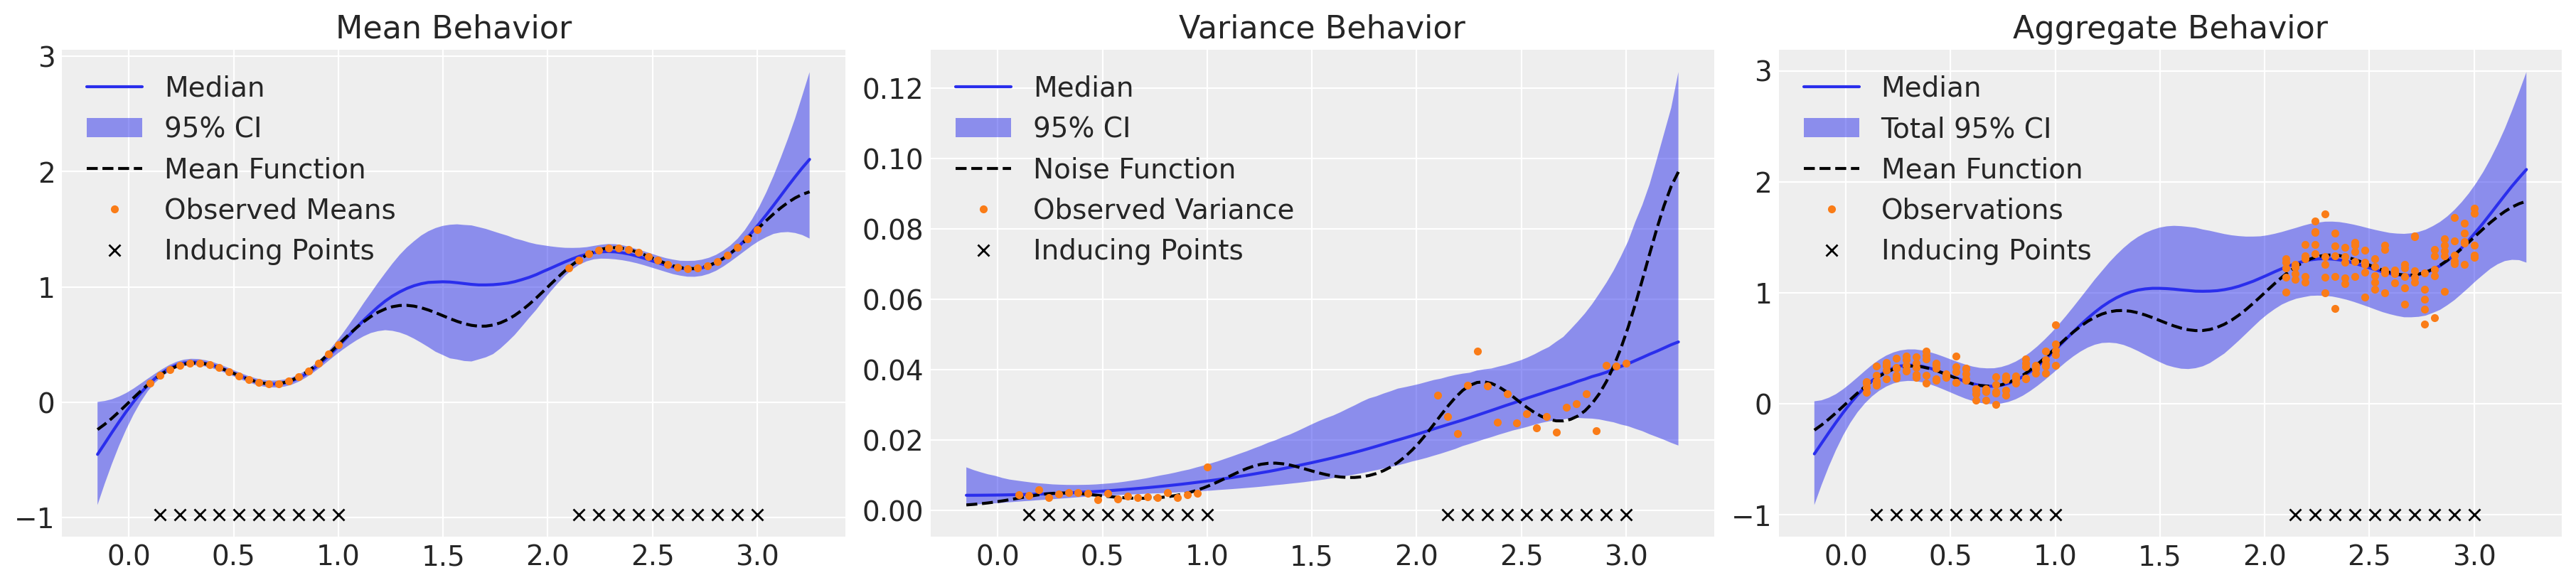

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(18, 4))
ppc_hts = samples_hts.posterior_predictive.stack(sample=("chain", "draw"))
μ_samples = ppc_hts["μ_pred"].values
σ_samples = np.exp(ppc_hts["lg_σ_pred"].values)
plot_mean(axs[0], μ_samples, sample_axis=1)
plot_inducing_points(axs[0])
plot_var(axs[1], σ_samples**2, sample_axis=1)
plot_inducing_points(axs[1])
plot_total(axs[2], μ_samples, σ_samples**2, sample_axis=1)
plot_inducing_points(axs[2])


That was ~8x faster with nearly indistinguishable results, and fewer divergences as well.

## Heteroskedastic GP with correlated noise and mean response: Linear Model of Coregionalization

So far, we've modeled the mean and noise of our system as independent. However, there may be scenarios where we expect them to be correlated, for example if higher measurement values are expected to have greater noise. Here, we'll explicitly model this correlation through a covariance function that is a Kronecker product of the spatial kernel we've used previously and a `Coregion` kernel, as suggested by Bill Engel [here](https://discourse.pymc.io/t/coregionalization-model-for-two-separable-multidimensional-gaussian-process/2550/4). This is an implementation of the Linear Model of Coregionalization, which treats each correlated GP as a linear combination of a small number of independent basis functions, which are themselves GPs. We first add a categorical dimension to the domain of our observations to indicate whether the mean or variance is being considered, then unpack the respective components before feeding them into a `Normal` likelihood as above.

In [ ]:
def add_coreg_idx(x):
    return np.hstack([np.tile(x, (2, 1)), np.vstack([np.zeros(x.shape), np.ones(x.shape)])])


Xu_c, X_obs_c, Xnew_c = (add_coreg_idx(x) for x in [Xu, X_obs, Xnew])

with pm.Model() as model_htsc:
    ℓ = pm.InverseGamma("ℓ", mu=ℓ_μ, sigma=ℓ_σ)
    η = pm.Gamma("η", alpha=2, beta=1)
    EQcov = η**2 * pm.gp.cov.ExpQuad(input_dim=1, active_dims=[0], ls=ℓ)

    D_out = 2  # two output dimensions, mean and variance
    rank = 2  # two basis GPs
    W = pm.Normal("W", mu=0, sigma=3, shape=(D_out, rank), initval=np.full([D_out, rank], 0.1))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=D_out)
    coreg = pm.gp.cov.Coregion(input_dim=1, active_dims=[0], kappa=kappa, W=W)

    cov = pm.gp.cov.Kron([EQcov, coreg])

    gp_LMC = SparseLatent(cov)
    LMC_f = gp_LMC.prior("LMC", X_obs_c, Xu_c)

    μ_f = LMC_f[: len(y_obs_)]
    lg_σ_f = LMC_f[len(y_obs_) :]
    σ_f = pm.Deterministic("σ_f", pm.math.exp(lg_σ_f))

    lik_htsc = pm.Normal("lik_htsc", mu=μ_f, sigma=σ_f, observed=y_obs_)
    trace_htsc = pm.sample(target_accept=0.95, return_inferencedata=True, random_seed=SEED)

with model_htsc:
    c_mu_pred = gp_LMC.conditional("c_mu_pred", Xnew_c, Xu_c)
    samples_htsc = pm.sample_posterior_predictive(trace_htsc, var_names=["c_mu_pred"])

Initializing NUTS using jitter+adapt_diag...
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, η, W, kappa, u_rotated_LMC]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5208 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling: [c_mu_pred]


Output()

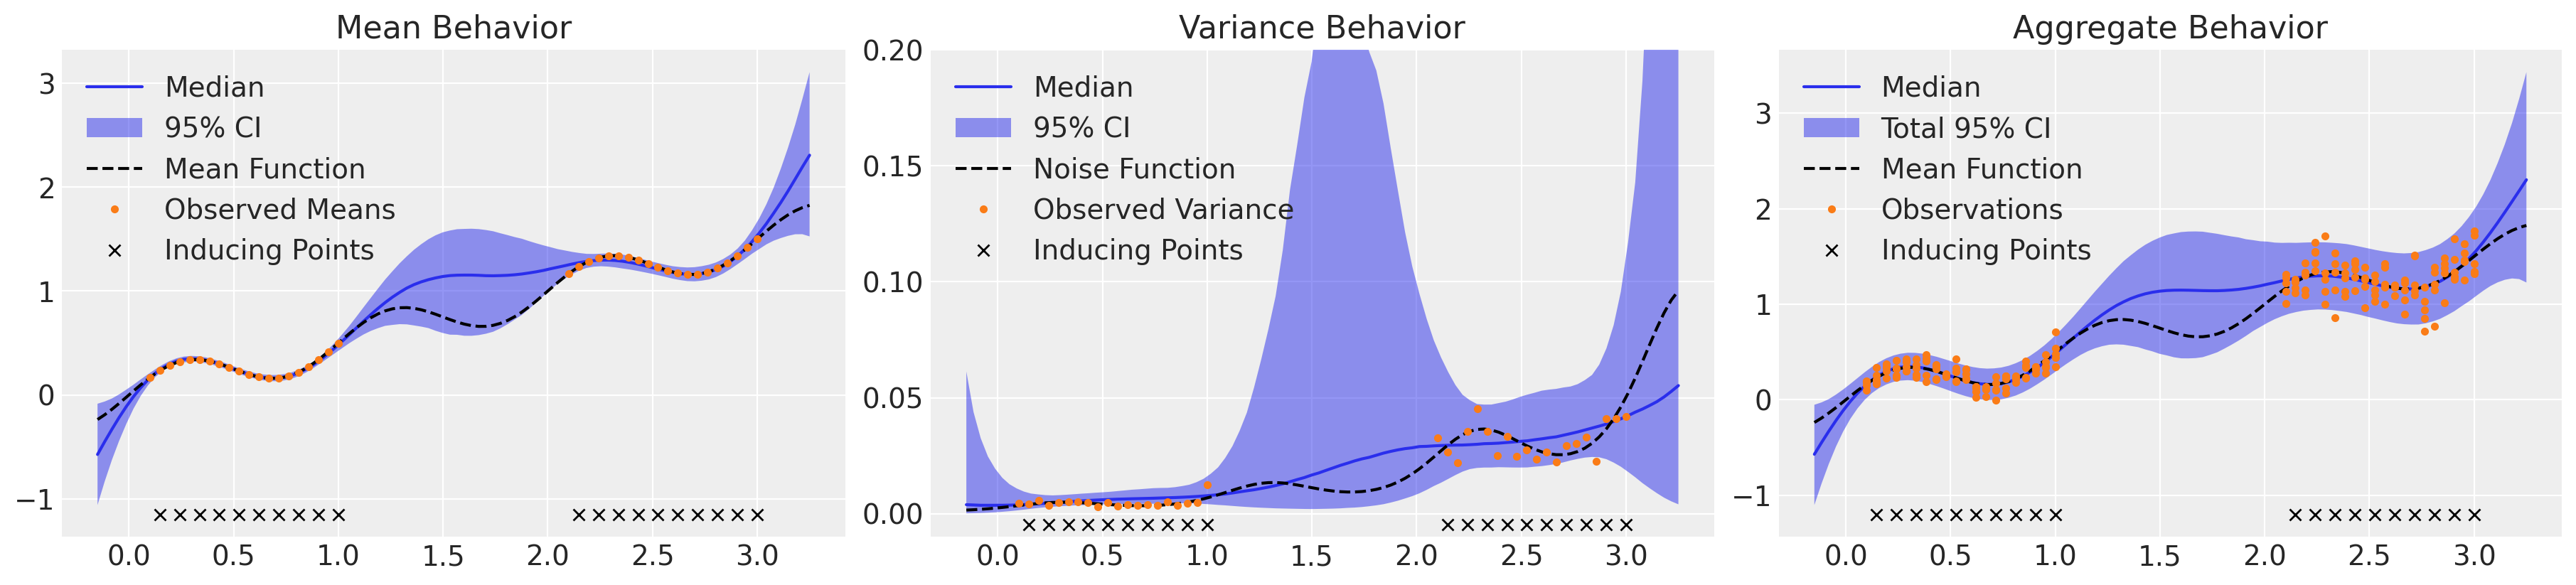

In [ ]:
c_mu_pred = samples_htsc.posterior_predictive.stack(sample=("chain", "draw"))["c_mu_pred"].values
μ_samples = c_mu_pred[: len(Xnew), :]
σ_samples = np.exp(c_mu_pred[len(Xnew) :, :])

_, axs = plt.subplots(1, 3, figsize=(18, 4))
plot_mean(axs[0], μ_samples, sample_axis=1)
plot_inducing_points(axs[0])
plot_var(axs[1], σ_samples**2, sample_axis=1)
axs[1].set_ylim(-0.01, 0.2)
axs[1].legend(loc="upper left")
plot_inducing_points(axs[1])
plot_total(axs[2], μ_samples, σ_samples**2, sample_axis=1)
plot_inducing_points(axs[2])


We can look at the learned correlation between the mean and variance by inspecting the covariance matrix $\bf{B}$ constructed via $\mathbf{B} \equiv \mathbf{WW}^T+diag(\kappa)$:

In [ ]:
with model_htsc:
    B_samples = pm.sample_posterior_predictive(trace_htsc, var_names=["W", "kappa"])

Sampling: [W, kappa]


Output()

In [ ]:
# Samples are stacked on the last dimension in all arrays
ppc_htsc = B_samples.posterior_predictive.stack(sample=("chain", "draw"))
W = ppc_htsc["W"].values
WW_T = np.einsum("drs,ers->des", W, W)

kappa = ppc_htsc["kappa"].values
I = np.identity(2)[:, :, None]
# einsum is just a concise way of doing multiplication and summation over arbitrary axes
diag_kappa = I * kappa[:, None, :]

B = WW_T + diag_kappa
B.mean(axis=2)


array([[19.40491486,  0.14502028],
       [ 0.14502028, 19.58195724]])

In [ ]:
sd = np.sqrt(np.diagonal(B, axis1=0, axis2=1))
outer_sd = np.einsum("ds,es->des", sd, sd)
correlation = B / outer_sd
print(f"2.5%ile correlation: {np.percentile(correlation,2.5,axis=2)[0,1]:0.3f}")
print(f"Median correlation: {np.percentile(correlation,50,axis=2)[0,1]:0.3f}")
print(f"97.5%ile correlation: {np.percentile(correlation,97.5,axis=2)[0,1]:0.3f}")


2.5%ile correlation: -0.916
Median correlation: 0.015
97.5%ile correlation: 0.924


The model has inadvertently learned that the mean and noise are negatively correlated, albeit with a wide credible interval.

## Comparison

The three latent approaches shown here varied in their complexity and efficiency, but ultimately produced very similar regression surfaces, as shown below. All three displayed a nuanced understanding of both aleatoric and epistemic uncertainties. It's worth noting that we had to increase `target_accept` from the default 0.8 to 0.95 to avoid an excessive number of divergences, but this has the downside of slowing down NUTS evaluations. Sampling times could be decreased by reducing `target_accept`, at the expense of potentially biased inference due to divergences, or by further reducing the number of inducing points used in the sparse approximations. Inspecting the convergence statistics for each method, all had low r_hat values of 1.01 or below, but the LMC model showed low effective sample sizes for some parameters, in particular the `ess_tail` for the η and ℓ parameters. To have confidence in the 95% CI bounds for this model, we should run the sampling for more iterations, ideally at least until the smallest `ess_tail` is above 200 but the higher the better.

### Regression surfaces

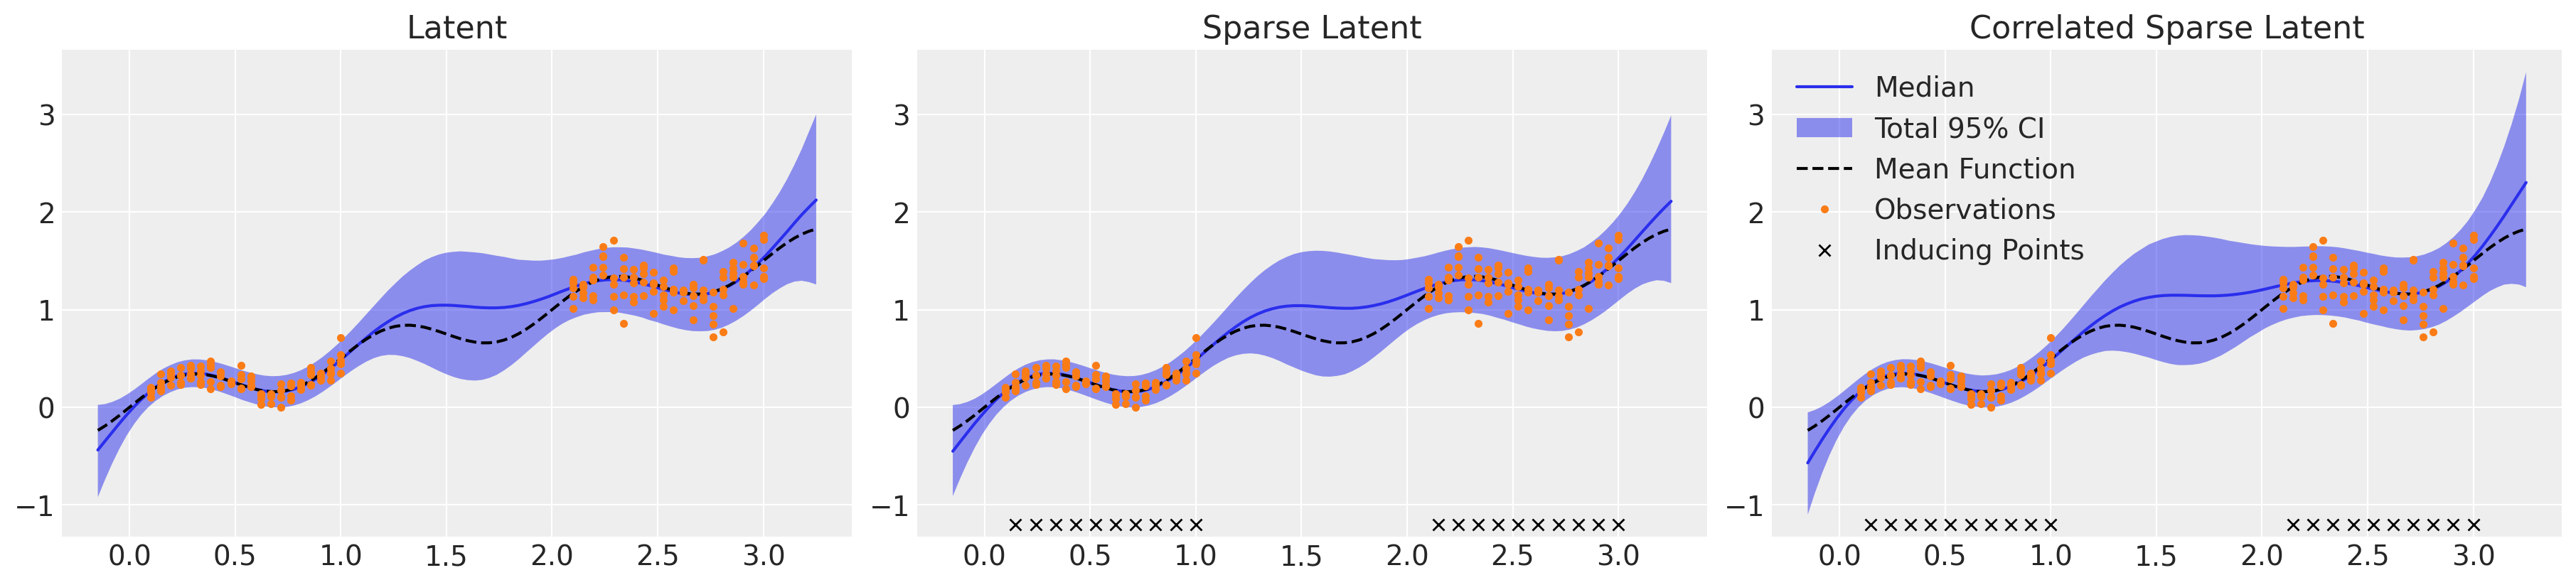

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(18, 4))

ppc_ht = samples_ht.posterior_predictive.stack(sample=("chain", "draw"))
μ_samples = ppc_ht["μ_pred_ht"].values
σ_samples = np.exp(ppc_ht["lg_σ_pred_ht"].values)
plot_total(axs[0], μ_samples, σ_samples**2, sample_axis=1)
axs[0].set_title("Latent")

ppc_hts = samples_hts.posterior_predictive.stack(sample=("chain", "draw"))
μ_samples = ppc_hts["μ_pred"].values
σ_samples = np.exp(ppc_hts["lg_σ_pred"].values)
plot_total(axs[1], μ_samples, σ_samples**2, sample_axis=1)
axs[1].set_title("Sparse Latent")

c_mu_pred = samples_htsc.posterior_predictive.stack(sample=("chain", "draw"))["c_mu_pred"].values
μ_samples = c_mu_pred[: len(Xnew), :]
σ_samples = np.exp(c_mu_pred[len(Xnew) :, :])
plot_total(axs[2], μ_samples, σ_samples**2, sample_axis=1)
axs[2].set_title("Correlated Sparse Latent")

yls = [ax.get_ylim() for ax in axs]
yl = [np.min([l[0] for l in yls]), np.max([l[1] for l in yls])]
for ax in axs:
    ax.set_ylim(yl)

plot_inducing_points(axs[1])
plot_inducing_points(axs[2])

axs[0].legend().remove()
axs[1].legend().remove()


### Latent model convergence

In [ ]:
display(az.summary(trace_ht).sort_values("ess_bulk").iloc[:5])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
η,1.917,0.761,0.752,3.396,0.031,0.031,607.0,750.0,1.01
μ_f_rotated_[0],0.100,0.042,0.032,0.178,0.002,0.001,668.0,1026.0,1.01
μ_f_rotated_[5],0.533,0.172,0.219,0.847,0.006,0.004,801.0,1055.0,1.00
ℓ,0.582,0.062,0.457,0.690,0.002,0.002,999.0,923.0,1.00
μ_f_rotated_[105],-0.100,0.634,-1.284,1.121,0.018,0.015,1204.0,1265.0,1.00


### Sparse Latent model convergence

In [ ]:
display(az.summary(trace_hts).sort_values("ess_bulk").iloc[:5])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
η,1.918,0.766,0.805,3.366,0.026,0.050,1117.0,1259.0,1.0
u_rotated_μ[0],0.144,0.055,0.054,0.247,0.002,0.001,1138.0,1312.0,1.0
u_rotated_μ[1],0.339,0.114,0.152,0.558,0.003,0.002,1355.0,1564.0,1.0
u_rotated_μ[2],-1.015,0.324,-1.629,-0.429,0.008,0.007,1756.0,1346.0,1.0
ℓ,0.582,0.058,0.477,0.693,0.001,0.001,2199.0,2740.0,1.0


### Correlated Sparse Latent model convergence

In [ ]:
display(az.summary(trace_htsc).sort_values("ess_bulk").iloc[:5])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
u_rotated_LMC[0],0.095,0.044,0.029,0.173,0.001,0.001,980.0,1314.0,1.0
u_rotated_LMC[1],0.248,0.095,0.098,0.425,0.003,0.002,1149.0,1380.0,1.0
ℓ,0.660,0.076,0.528,0.809,0.002,0.001,1292.0,1762.0,1.0
η,0.894,0.431,0.245,1.632,0.013,0.018,1300.0,1235.0,1.0
u_rotated_LMC[2],-0.911,0.289,-1.464,-0.416,0.008,0.005,1520.0,1785.0,1.0


## Authors
- This notebook was written by John Goertz on 5 May, 2021.
- Updated by Christopher Krapu on December 21, 2025 for v5 compatibility.


## References
:::{bibliography}
:filter: docname in docnames
:::


## Watermark


In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Sun Dec 21 2025

Python implementation: CPython
Python version       : 3.13.11
IPython version      : 9.8.0

xarray: 2025.12.0

pymc      : 5.26.1
matplotlib: 3.10.8
arviz     : 0.22.0
numpy     : 2.3.5
scipy     : 1.16.3
pytensor  : 2.35.1

Watermark: 2.5.0



:::{include} ../page_footer.md
:::
